In [ ]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [ ]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [ ]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [ ]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

In [ ]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Activation, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 20 # 訓練的 epochs 數量

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
model = Sequential()

# conv block 1
model.add(Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=x_train.shape[1:]) )
model.add(Conv2D(64, (3, 3), padding="same" , activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
# conv block 2
model.add(Conv2D(128, (3, 3), padding='same',activation="relu"))
model.add(Conv2D(128, (3, 3), padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# conv block 3
model.add(Conv2D(256, (3, 3), padding='same',activation="relu"))
model.add(Conv2D(256, (3, 3), padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
# dense block
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.01))
model.add(Dense(10, activation='softmax'))

In [4]:
""" 產生generator
"""
gen = ImageDataGenerator(rotation_range=45, # 隨機轉動的角度
                         width_shift_range=0.2, # 水平偏移的幅度
                         height_shift_range=0.2, # 垂直偏移的幅度
                         shear_range=0.3, # 剪切強度
                         zoom_range=0.2, # 隨機縮放的強度
                         horizontal_flip=True, # 水平翻轉
                         vertical_flip=True # 垂直翻轉 
                        )
gen.fit(x_train)
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

In [5]:
opt = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit_generator(train_generator, 
                              steps_per_epoch=len(x_train) / batch_size, 
                              epochs=epochs, 
                              validation_data=(x_test, y_test))

Epoch 1/20
391/390 [==============================] - 37s 94ms/step - loss: 2.0400 - acc: 0.3011 - val_loss: 1.7567 - val_acc: 0.3867
Epoch 2/20
391/390 [==============================] - 31s 79ms/step - loss: 1.7298 - acc: 0.3791 - val_loss: 1.8966 - val_acc: 0.3715
Epoch 3/20
391/390 [==============================] - 32s 81ms/step - loss: 1.6301 - acc: 0.4112 - val_loss: 1.6892 - val_acc: 0.4286
Epoch 4/20
391/390 [==============================] - 33s 84ms/step - loss: 1.5596 - acc: 0.4372 - val_loss: 2.0104 - val_acc: 0.3804
Epoch 5/20
391/390 [==============================] - 32s 81ms/step - loss: 1.5041 - acc: 0.4597 - val_loss: 1.6434 - val_acc: 0.4527
Epoch 6/20
391/390 [==============================] - 31s 80ms/step - loss: 1.4474 - acc: 0.4795 - val_loss: 1.7068 - val_acc: 0.4326
Epoch 7/20
391/390 [==============================] - 31s 80ms/step - loss: 1.3998 - acc: 0.4977 - val_loss: 1.8540 - val_acc: 0.4120
Epoch 8/20
391/390 [==============================] - 31s 80ms

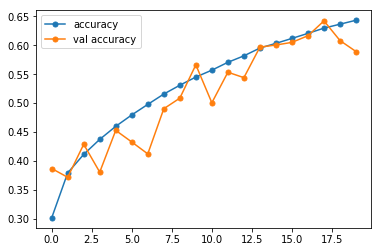

In [6]:
# 畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2292630896568297
Test accuracy: 0.5892
